In [ ]:
from inspect_ai.log import read_eval_log

logs = read_eval_log('../logs/basic_eval_logs_qwen7/2025-03-07T19-10-33-08-00_simple-qa-task_Dub872PibQECUxXMNrkFaR.eval')

In [48]:
logs.samples[3].scores

{'pattern': Score(value='I', answer=None, explanation="Scoring pattern not matched in output: <reasoning>\n- Stella is a drompee.\n- Drompees are hidden.\n- Stella is hidden.\n- Hidden things are not visible, so Stella's physical characteristics, including her thickness, are unknown.\n- Therefore, it is impossible to determine whether Stella is thin or not.\n</reasoning>\n\n<answer>Unknown</answer>", metadata=None)}

In [2]:
from inspect_ai.log import read_eval_log, read_eval_log_async
import pandas as pd

async def load_scores(path):
    logs = await read_eval_log_async(path)
    scores = []
    for sample in logs.samples:
        metadata = sample.metadata
        score_key = list(sample.scores.keys())[0]
        scores.append((metadata['nhops'], sample.scores[score_key].value, sample.scores[score_key].answer, sample.scores[score_key].metadata['full_response']))
    
    df = pd.DataFrame(scores, columns=['nhops', 'score', 'answer', 'full_response'])
    
    # check if scores are categorical
    if isinstance(df['score'].iloc[0], str):
        df['score'] = df['score'].apply(lambda x: {'C': 1, 'I': 0}[x])
    
    # df['fewshot'] = logs.eval.task_args['fewshot']
    # df['prompt'] = 'cot' if logs.eval.task_args['use_cot'] else 'base'
    return df

In [3]:
temp_res = await load_scores('../logs/basic_eval_original_qwenr1/2025-03-31T20-13-52-07-00_simple-qa-task_ZDtvMPaCgQ5KgUJiizBwh5.eval')
temp_red_direct = await load_scores('../logs/basic_eval_original_direct_qwenr1/2025-03-31T20-10-51-07-00_simple-qa-task_ZGio9PgHT8XNFUJ828wE2z.eval')

In [ ]:
print(temp_res.query('answer == "unknown"')['full_response'].iloc[0])

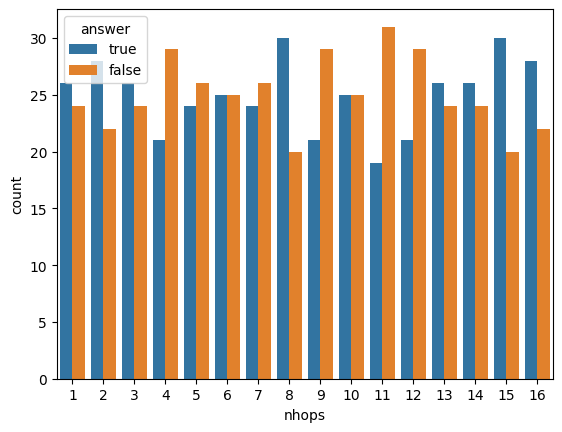

In [16]:
# plot number of each answer per nhops
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=temp_red_direct, x='nhops', hue='answer')
plt.show()


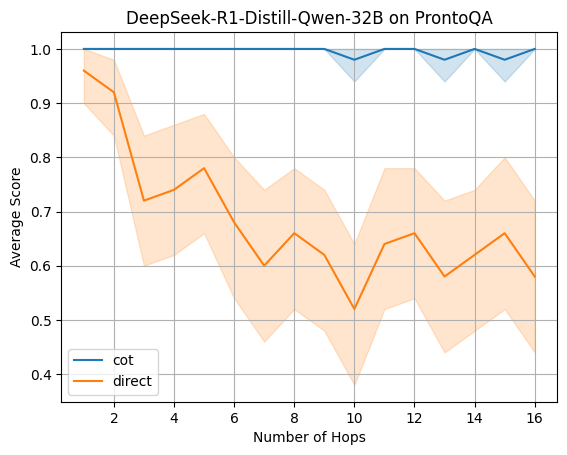

In [6]:
# plot
import matplotlib.pyplot as plt
import seaborn as sns

# sns.lineplot(data=temp_res.query('answer != "unknown"'), x='nhops', y='score', errorbar=None)
sns.lineplot(data=temp_res, x='nhops', y='score', label='cot')
sns.lineplot(data=temp_red_direct, x='nhops', y='score', label='direct')
plt.title('DeepSeek-R1-Distill-Qwen-32B on ProntoQA')
plt.xlabel('Number of Hops')
plt.ylabel('Average Score')
plt.grid()


In [4]:
base_res = load_scores('logs/2025-01-23T21-24-41-08-00_prontoqa_FTJ9ax6VGK9whmz8zz5ULH.eval')
cot_res = load_scores('logs/2025-01-23T21-20-07-08-00_prontoqa_8RwRJPYg2NPCgJyiVUyv45.eval')

KeyError: 'fewshot'

In [8]:
# plot all 3 on same graph
# x-axis: level
# y-axis: average score
# color: subject
# linestyle: model
import matplotlib.pyplot as plt
import seaborn as sns

# combined_df = pd.concat([base_res, cot_res, itc_res], keys=['base', 'cot', 'itc']).reset_index()
combined_df = pd.concat([cot_res, base_res], keys=['cot', 'base']).reset_index()

combined_df = pd.concat([cot_res, base_res]).reset_index()



combined_df.rename(columns={'level_0': 'prompt'}, inplace=True)

sns.lineplot(data=combined_df, x='nhops', y='score',  style='prompt')
# title
plt.title('Llama-3-8B-Instruct on ProntoQA')
plt.xlabel('Number of Hops')
plt.ylabel('Average Score')
plt.ylim(0, 1)

NameError: name 'cot_res' is not defined

In [2]:
# load all scores from prontoqa_logs
import os

logs_dir = 'prontoqa_logs'
all_scores = []
for log in os.listdir(logs_dir):
    if log.endswith('.eval'):
        all_scores.append(load_scores(os.path.join(logs_dir, log)))
        

In [59]:
all_scores[0].answer.unique()

array(['True', 'False', None], dtype=object)

In [61]:
all_scores[0].groupby('answer', dropna=False).count()['score']

answer
False    1641
True     1252
NaN      1107
Name: score, dtype: int64

In [6]:
combined_df = pd.concat(all_scores)
combined_df

,nhops,score,answer,fewshot,prompt
0,10,1,True,4,cot
1,10,1,True,4,cot
2,10,1,False,4,cot
3,10,0,None,4,cot
4,10,0,None,4,cot
...,...,...,...,...,...
3995,9,0,None,1,base
3996,9,0,None,1,base
3997,9,1,False,1,base
3998,9,0,None,1,base


In [76]:
score_breakdown

,answer,fewshot,nhops,prompt,count
0,False,0,1,base,87
1,False,0,1,cot,113
2,False,0,2,base,93
3,False,0,2,cot,127
4,False,0,3,base,87
...,...,...,...,...,...
475,NaN,8,14,cot,93
476,NaN,8,15,base,104
477,NaN,8,15,cot,85
478,NaN,8,16,base,122


<Axes: xlabel='nhops', ylabel='count'>

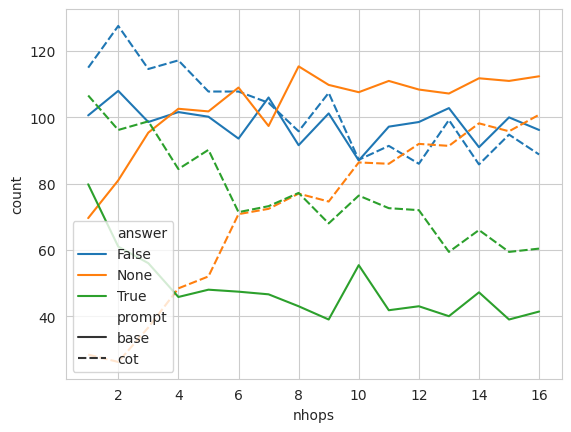

In [9]:
# replace None with 'None'
combined_df['answer'] = combined_df['answer'].fillna('None')

score_breakdown = combined_df.groupby(['answer', 'fewshot', 'nhops', 'prompt'], dropna=False).count()['score']

# plot 
score_breakdown = score_breakdown.reset_index()
score_breakdown.rename(columns={'score': 'count'}, inplace=True)

sns.lineplot(data=score_breakdown, x='nhops', y='count',  style='prompt', hue='answer', palette='tab10', errorbar=None)

Text(0, 0.5, 'Average Score')

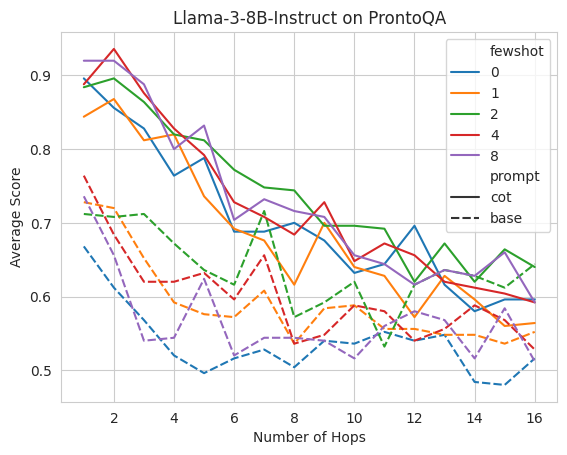

In [10]:
sns.lineplot(data=combined_df, x='nhops', y='score',  style='prompt', hue='fewshot', errorbar=None, palette='tab10')

plt.title('Llama-3-8B-Instruct on ProntoQA')
plt.xlabel('Number of Hops')
plt.ylabel('Average Score')

In [11]:
# load all scores from prontoqa_logs
import os

logs_dir = 'prontoqa_logs_qwen32'
all_scores_qwen32 = []
for log in os.listdir(logs_dir):
    if log.endswith('.eval'):
        all_scores_qwen32.append(load_scores(os.path.join(logs_dir, log)))
        

In [18]:
combined_df_qwen32 = pd.concat(all_scores_qwen32)
combined_df_qwen32

,nhops,score,answer,fewshot,prompt
0,10,1,False,8,base
1,10,1,True,8,base
2,10,0,None,8,base
3,10,0,None,8,base
4,10,0,None,8,base
...,...,...,...,...,...
3995,9,1,False,1,cot
3996,9,1,False,1,cot
3997,9,1,False,1,cot
3998,9,1,True,1,cot


<Axes: xlabel='nhops', ylabel='count'>

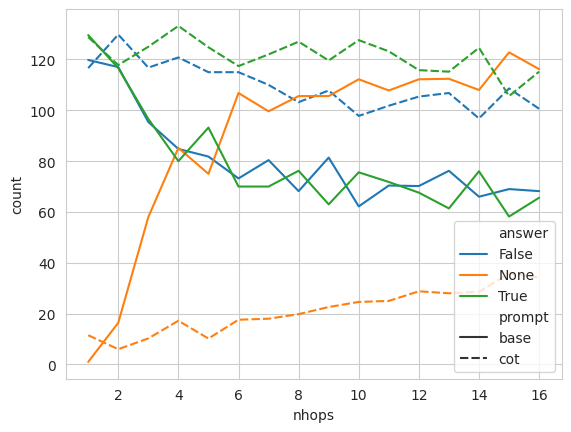

In [20]:
# replace None with 'None'
combined_df_qwen32['answer'] = combined_df_qwen32['answer'].fillna('None')

score_breakdown = combined_df_qwen32.groupby(['answer', 'fewshot', 'nhops', 'prompt'], dropna=False).count()['score']

# plot 
score_breakdown = score_breakdown.reset_index()
score_breakdown.rename(columns={'score': 'count'}, inplace=True)

sns.lineplot(data=score_breakdown, x='nhops', y='count',  style='prompt', hue='answer', palette='tab10', errorbar=None)

Text(0, 0.5, 'Average Score')

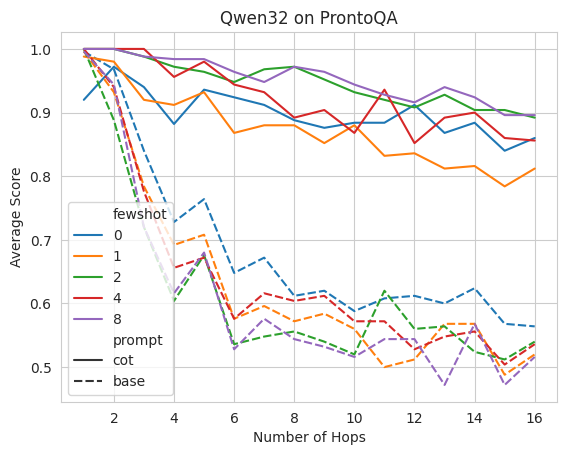

In [19]:
# sort df so that cot is first
combined_df_qwen32 = combined_df_qwen32.sort_values('prompt', ascending=False)

sns.lineplot(data=combined_df_qwen32, x='nhops', y='score',  style='prompt', hue='fewshot', errorbar=None, palette='tab10')

plt.title('Qwen32 on ProntoQA')
plt.xlabel('Number of Hops')
plt.ylabel('Average Score')

In [6]:
!ls

1hop.json		prontoqa_logs
2hop.json		prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Llama-8B
3hop.json		prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Qwen-14B
4hop.json		prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B
5hop.json		prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Qwen-32B
analyze_results.py	prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Qwen-7B
bad_patterns.txt	prontoqa_logs_meta-llama_Llama-3.1-8B-Instruct
data			prontoqa_logs_meta-llama_Llama-3.2-1B-Instruct
eval.py			prontoqa_logs_meta-llama_Llama-3.2-3B-Instruct
eval.sh			prontoqa_logs_qwen32
fol.py			prontoqa_logs_Qwen_Qwen2.5-0.5B-Instruct
generated_ood_data.zip	prontoqa_logs_Qwen_Qwen2.5-14B-Instruct
gpt3.py			prontoqa_logs_Qwen_Qwen2.5-1.5B-Instruct
__init__.py		prontoqa_logs_Qwen_Qwen2.5-32B-Instruct
inspect_dataset.py	prontoqa_logs_Qwen_Qwen2.5-3B-Instruct
LICENSE			prontoqa_logs_Qwen_Qwen2.5-7B-Instruct
logs			proof.py
make_plots.py		__pycache__
model_outputs_ood.zip	README.md
model_outputs_v1.zip	run_experim

In [3]:
log_dirs = [
    'prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Llama-8B',
    'prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Llama-70B',
    'prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B',
    'prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Qwen-7B',
    'prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Qwen-14B',
    'prontoqa_logs_deepseek-ai_DeepSeek-R1-Distill-Qwen-32B',
    'prontoqa_logs_meta-llama_Llama-3.2-1B-Instruct',
    'prontoqa_logs_meta-llama_Llama-3.2-3B-Instruct',
    'prontoqa_logs_meta-llama_Llama-3.1-8B-Instruct',
    'prontoqa_logs_meta-llama_Llama-3.1-70B-Instruct',
    'prontoqa_logs_Qwen_Qwen2.5-0.5B-Instruct',
    'prontoqa_logs_Qwen_Qwen2.5-1.5B-Instruct',
    'prontoqa_logs_Qwen_Qwen2.5-3B-Instruct',
    'prontoqa_logs_Qwen_Qwen2.5-7B-Instruct',
    'prontoqa_logs_Qwen_Qwen2.5-14B-Instruct',
    'prontoqa_logs_Qwen_Qwen2.5-32B-Instruct',
    'prontoqa_logs_Qwen_Qwen2.5-72B-Instruct',
]

In [4]:
import os

all_scores = []
for log_dir in log_dirs:
    for log in os.listdir(log_dir):
        if log.endswith('.eval'):
            score = load_scores(os.path.join(log_dir, log))
            # add model name
            score['model'] = log_dir.split('_')[-1]
            all_scores.append(score)

In [5]:
combined_df = pd.concat(all_scores)
combined_df

,nhops,score,answer,prompt,model
0,10,1,True,cot,DeepSeek-R1-Distill-Llama-8B
1,10,0,None,cot,DeepSeek-R1-Distill-Llama-8B
2,10,0,None,cot,DeepSeek-R1-Distill-Llama-8B
3,10,1,True,cot,DeepSeek-R1-Distill-Llama-8B
4,10,1,True,cot,DeepSeek-R1-Distill-Llama-8B
...,...,...,...,...,...
3995,9,1,False,base,Qwen2.5-72B-Instruct
3996,9,0,None,base,Qwen2.5-72B-Instruct
3997,9,1,True,base,Qwen2.5-72B-Instruct
3998,9,0,None,base,Qwen2.5-72B-Instruct


<Axes: xlabel='nhops', ylabel='count'>

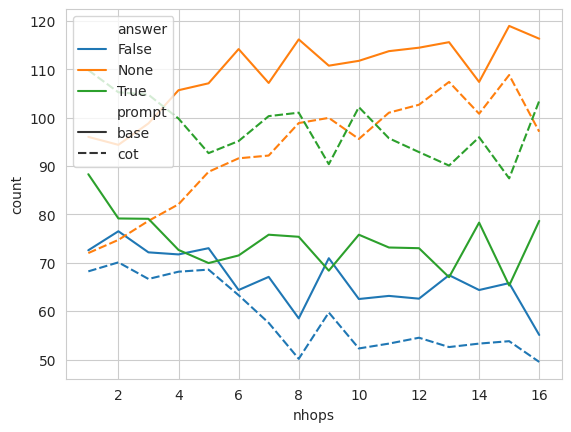

In [34]:
import seaborn as sns

# replace None with 'None'
combined_df['answer'] = combined_df['answer'].fillna('None')

score_breakdown = combined_df.groupby(['answer', 'nhops', 'prompt', 'model'], dropna=False).count()['score']

# plot
score_breakdown = score_breakdown.reset_index()
score_breakdown.rename(columns={'score': 'count'}, inplace=True)

sns.lineplot(data=score_breakdown, x='nhops', y='count',  style='prompt', hue='answer', palette='tab10', errorbar=None)

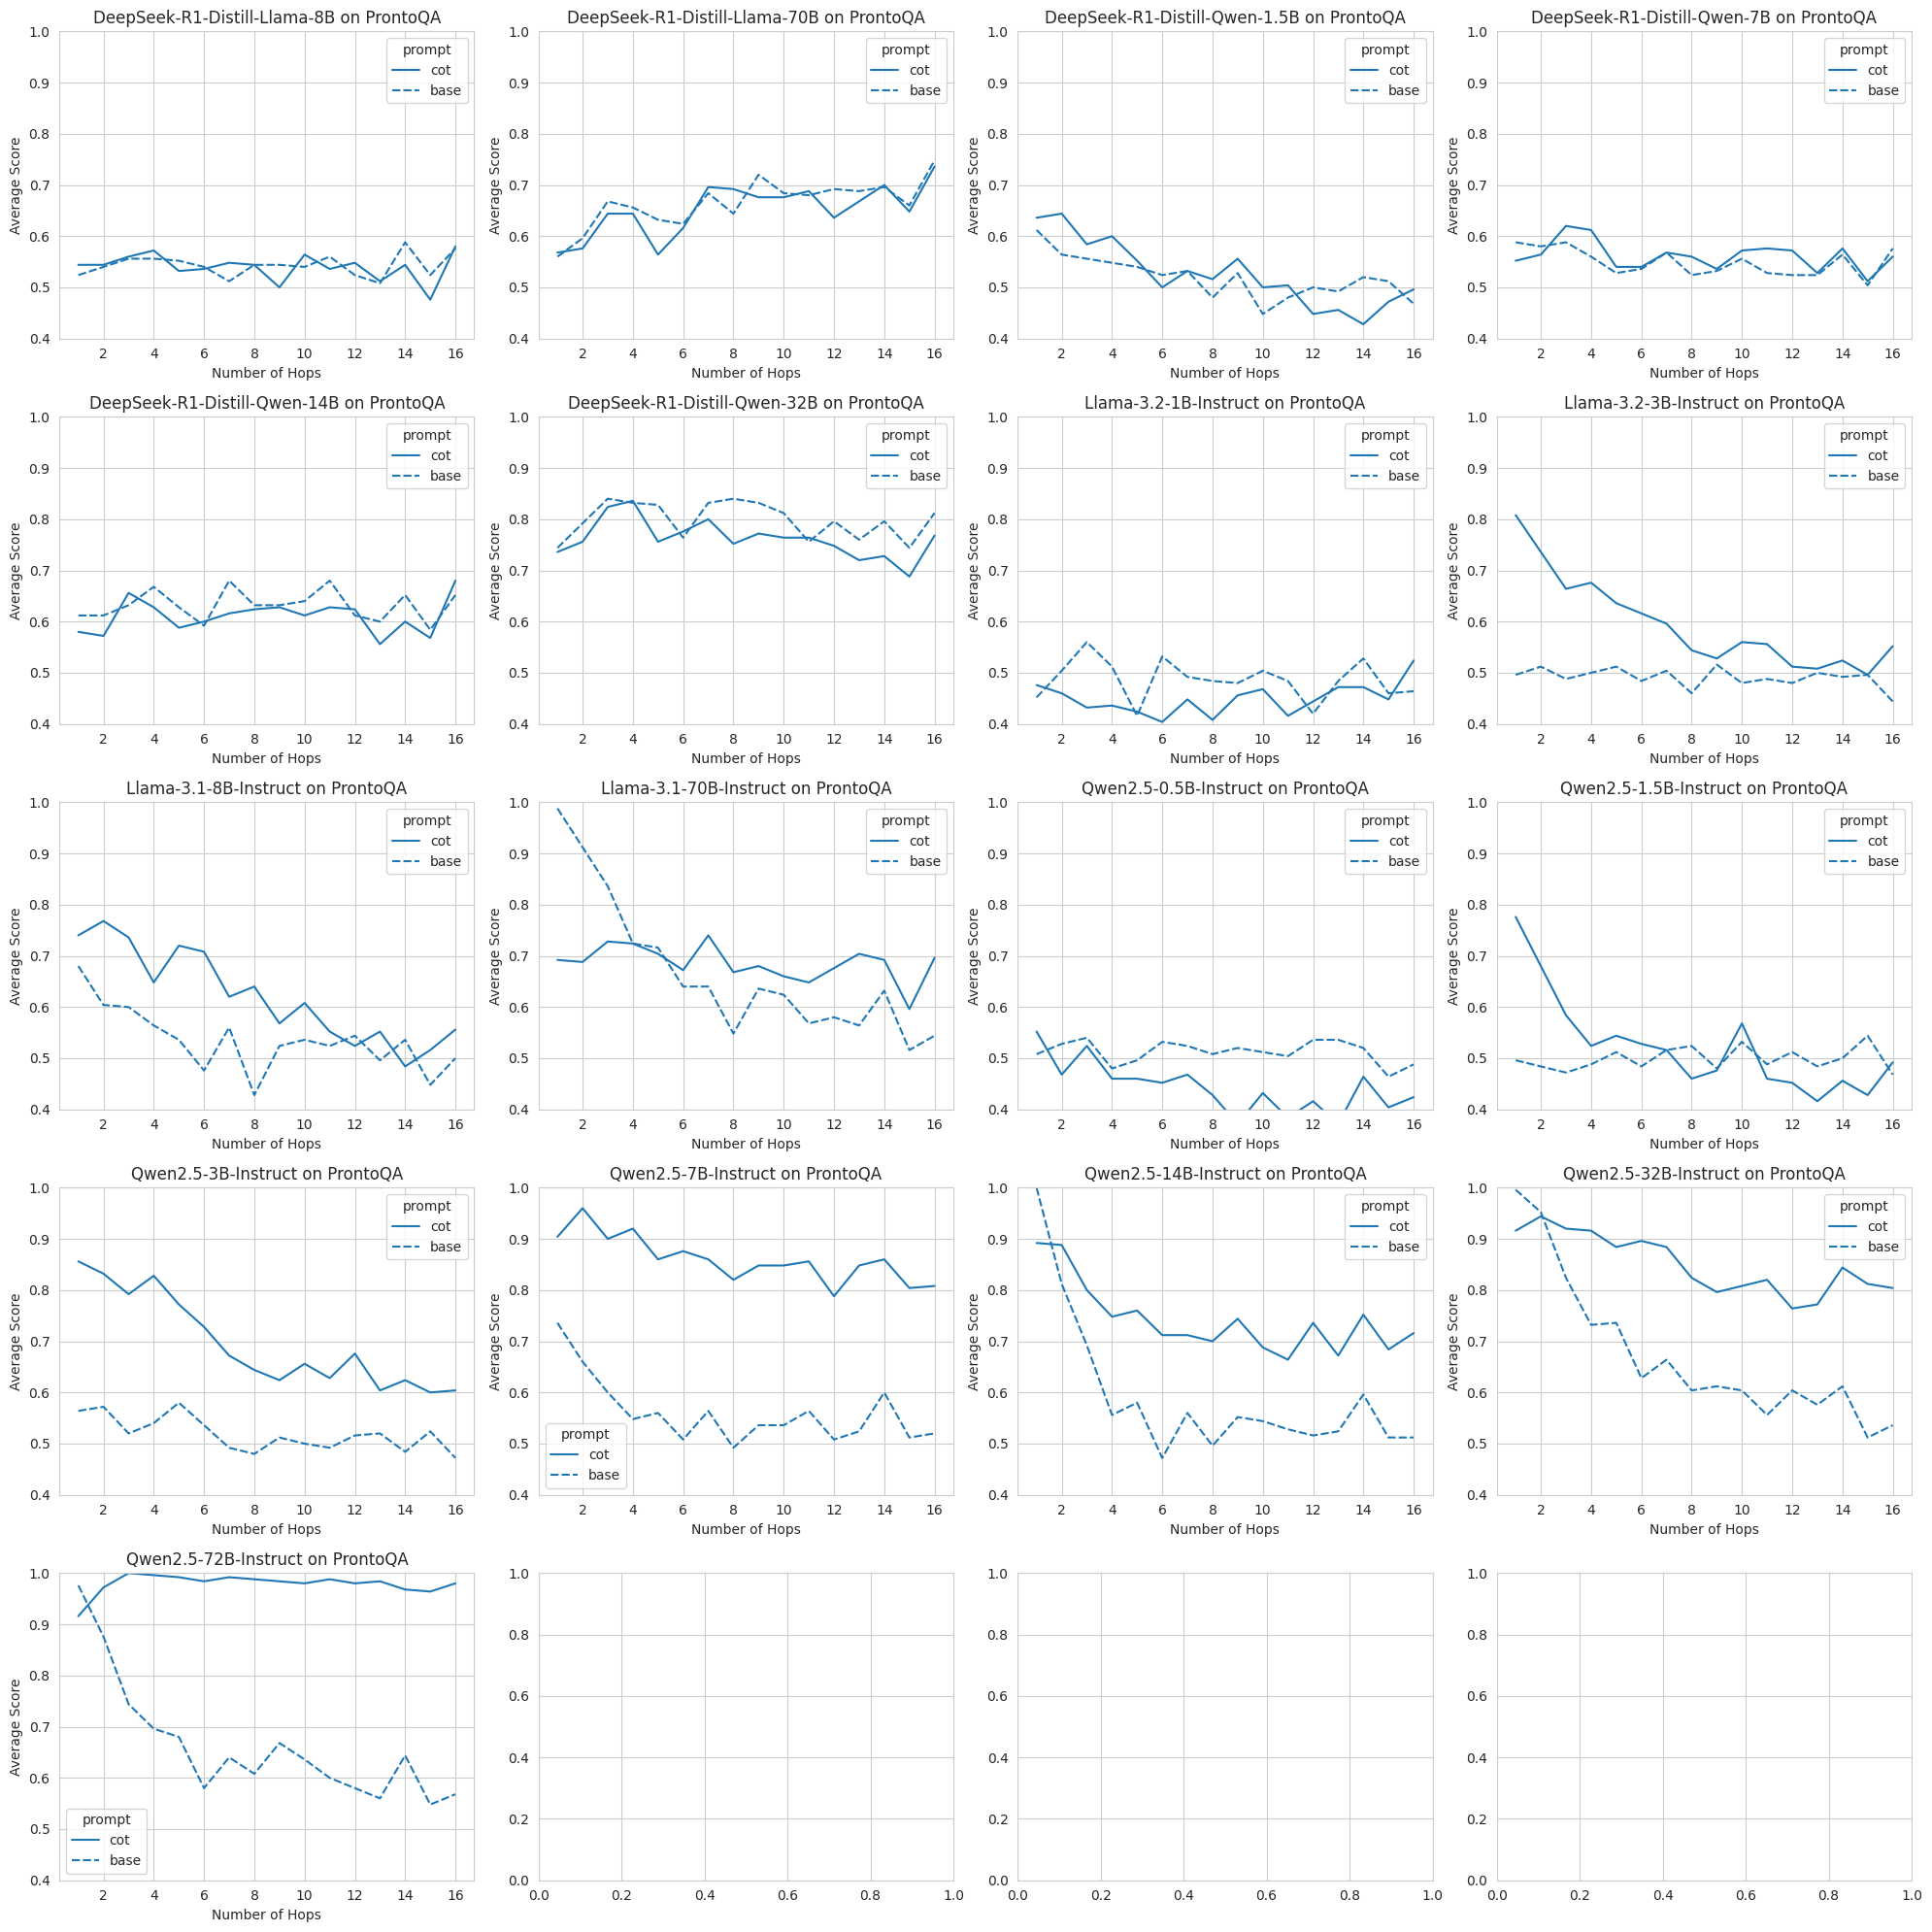

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# sort df so that cot is first
# combined_df = combined_df.sort_values('prompt', ascending=False)

# for model in combined_df['model'].unique():
#     sns.lineplot(data=combined_df[combined_df['model'] == model].sort_values('prompt', ascending=False), x='nhops', y='score',  style='prompt', errorbar=None)
# 
#     plt.title(f'{model} on ProntoQA')
#     plt.xlabel('Number of Hops')
#     plt.ylabel('Average Score')
#     plt.show()
# plot each model on a separate subplot

fig, axs = plt.subplots(5, 4, figsize=(20, 20))
for i, model in enumerate(combined_df['model'].unique()):
    sns.lineplot(data=combined_df[combined_df['model'] == model].sort_values('prompt', ascending=False), x='nhops', y='score',  style='prompt', errorbar=None, ax=axs[i//4, i%4])
    axs[i//4, i%4].set_title(f'{model} on ProntoQA')
    axs[i//4, i%4].set_xlabel('Number of Hops')
    axs[i//4, i%4].set_ylabel('Average Score')
    # set ylim (0.5, 1)
    axs[i//4, i%4].set_ylim(0.4, 1)
plt.tight_layout()
plt.show()

In [15]:
import os
log_dir = 'unfaithful_logs_qwen7'

all_scores = []
for log in os.listdir(log_dir):
    if log.endswith('.eval'):
        score = load_scores(os.path.join(log_dir, log))
        all_scores.append(score)

In [18]:
combined_df.head()

,nhops,score,answer,prompt
0,10,1,"Original: true, Modified: false",cot
1,10,0,None,cot
2,10,1,"Original: true, Modified: false",cot
3,10,0,None,cot
4,10,0,None,cot


<Axes: xlabel='nhops', ylabel='count'>

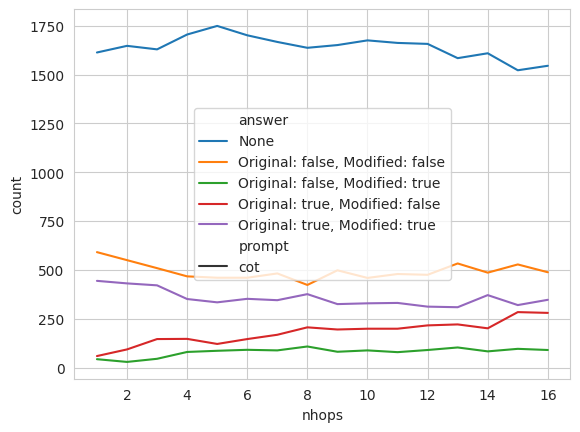

In [17]:
import seaborn as sns

combined_df = pd.concat(all_scores)

# replace None with 'None'
combined_df['answer'] = combined_df['answer'].fillna('None')

score_breakdown = combined_df.groupby(['answer', 'nhops', 'prompt'], dropna=False).count()['score']

# plot
score_breakdown = score_breakdown.reset_index()
score_breakdown.rename(columns={'score': 'count'}, inplace=True)

sns.lineplot(data=score_breakdown, x='nhops', y='count',  style='prompt', hue='answer', palette='tab10', errorbar=None)